Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


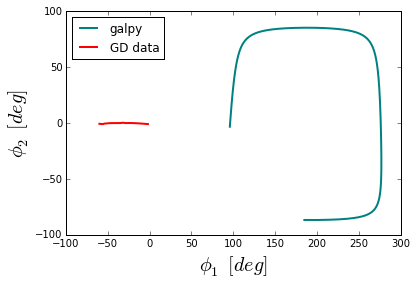

In [1]:
from   GD1_funcs    import *
import mw_transform as     mw

%pylab inline


# initial positions in cartesian coordinates in natural units
xi,yi,zi = np.array([-3.41,13.00,9.58])/distance  # (kpc) in natural units

# initial velocities in cartesian coordinates in natural units
vxi,vyi,vzi = np.array([-200.4,-162.6,13.9])/220. # (km/s) in natural units


# initial coordinates in cylindrical coordinates
Ri,zcyli,phii = xyz_to_cyl(xi,yi,zi) # phi is in radians


# initial velocities in cylindrical coordinates
vri,vti,vzcyli = vxvyvz_to_vrvtvz(xi,yi,zi,vxi,vyi,vzi)

phii *= 180./np.pi  # in degrees to use in orbit initialization

# calling the potential
p    = potential.LogarithmicHaloPotential(q=0.9,normalize=1)

# initiating the orbit
ts   = 1000 # number of timesteps
time = np.linspace(0.,1e1,ts)
o    = Orbit(vxvv=[Ri,vri,vti,zcyli,vzcyli,phii],ro=8.5,vo=220.)

o.integrate(time,p)

#### galpy values ####
RA  = o.ra(time,ro=distance,obs=[distance,0.])   # in degrees
DEC = o.dec(time,ro=distance,obs=[distance,0.])  # in degrees


func = np.vectorize(radec_to_phi12)

PHI1,PHI2 = func(RA,DEC,degree=True) # phi1 and phi2 are in radians

PHI1 *= 180./np.pi # in degrees
PHI2 *= 180./np.pi # in degrees

##### RA and Dec to lb --> phi1 and phi2 using Jo's code  #####
lb_test = mw.radec_to_lb(RA,DEC,degree=True,epoch=2000.0)
l_test  = lb_test.T[0] # in degree
b_test  = lb_test.T[1] # in degree

phi_test  = mw.lb_to_phi12(l_test,b_test,degree=True)
phi1_test = (phi_test.T[0]) * 180./np.pi
phi2_test = (phi_test.T[1]) * 180./np.pi



###### paper data #####
phi1,phi2,phi2_err = table2_kop2010()

plt.ion()
plt.plot(PHI1,PHI2,linewidth=2,color='teal',label='galpy')
plt.plot(phi1,phi2,linewidth=2,color='red',label='GD data')
#plt.plot(phi1_test,phi2_test,'o',label='lb to phi')
plt.legend(loc='best')
plt.xlabel("$\phi_1 \, [deg]$",fontsize=20)
plt.ylabel("$\phi_2 \, [deg]$",fontsize=20)
#plt.ylabel("$\ph2_1\,[deg]$",fontsize=20)


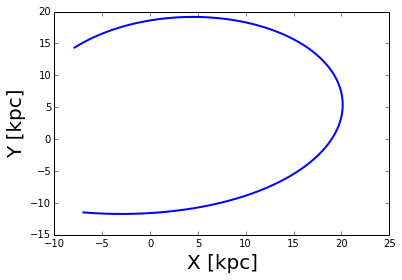

In [8]:
plt.plot(o.x(time),o.y(time),linewidth=2)
plt.xlabel("X [kpc]", fontsize=20)
plt.ylabel("Y [kpc]",fontsize=20)

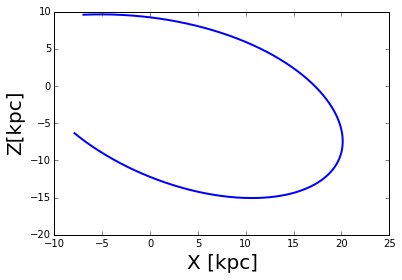

In [9]:
plt.plot(o.x(time),o.z(time),linewidth=2)
plt.xlabel("X [kpc]", fontsize=20)
plt.ylabel("Z[kpc]",fontsize=20)

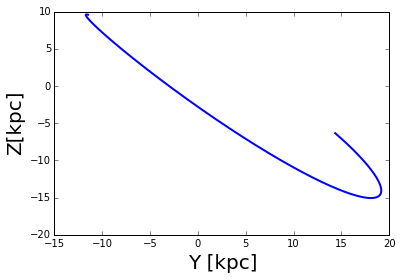

In [10]:
plt.plot(o.y(time),o.z(time),linewidth=2)
plt.xlabel("Y [kpc]", fontsize=20)
plt.ylabel("Z[kpc]",fontsize=20)